In [1]:
%cd ~/p/npworks/20200222-Vero-SCV2/

/blaze/hyeshik/p/npworks/20200222-Vero-SCV2


In [2]:
from Bio import SeqIO
covseq = str(next(SeqIO.parse(open('refs/SARS-CoV-2.fa'), 'fasta')).seq)

In [3]:
import h5py

In [4]:
with h5py.File('basemod/flg-stats/E-perread.tombo.per_read_stats', 'r') as h5:
    for blk in h5['Statistic_Blocks'].values():
        print(pd.DataFrame(blk['block_stats'][:1000]))
        break

       pos      stat  read_id
0    26237  0.675254      307
1    26238  0.705823      307
2    26239  0.856713      307
3    26240  0.896161      307
4    26241  0.956311      307
..     ...       ...      ...
995  27232  0.740617      307
996  27233  0.621217      307
997  27234  0.850875      307
998  27235  0.560653      307
999  27236  0.714492      307

[1000 rows x 3 columns]


In [5]:
sys.path.append('/blaze/hyeshik/nest/tink/gh/poreplex/master')
from poreplex import fast5_file

In [6]:
from glob import glob

In [7]:
from sklearn.linear_model import TheilSenRegressor

In [8]:
kmer_model = \
pd.read_csv('/blaze/hyeshik/nest/tink/gh/poreplex/master/poreplex/kmer_models/r9.4_180mv_70bps_5mer_RNA/template_median69pA.model',
           sep='\t').set_index('kmer', drop=True)
kmer_mean = kmer_model['level_mean'].to_dict()

In [10]:
from scipy.interpolate import CubicSpline
import statsmodels
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import medfilt

In [11]:
import random

In [12]:
scaling_ivt = pd.read_csv('stats/IVT1.scaling_params.txt',
                          sep='\t', names=['read_id', 'scale', 'shift']).set_index('read_id')
scaling_vir = pd.read_csv('stats/VeroInf24h.scaling_params.txt',
                          sep='\t', names=['read_id', 'scale', 'shift']).set_index('read_id')
scaling = pd.concat([scaling_ivt, scaling_vir])

In [13]:
RESQUIGGLE_WIDTH = 20

def load_fast5_alignment(filename, start, end, corrected_group):
    read_id = filename.split('/')[-1].split('.')[0]

    with fast5_file.Fast5Reader(filename, read_id) as f5:
        h5 = f5.handle
        try:
            tnode = h5['Analyses/'+corrected_group+'/BaseCalled_template']
        except KeyError:
            return None
        alnattrs = dict(tnode['Alignment'].attrs)
        
        if alnattrs['mapped_start'] > start or alnattrs['mapped_end'] < end:
            return None

        offset = tnode['Events'].attrs['read_start_rel_to_raw']
        rawsignal = f5.get_raw_data()[:-offset][::-1]
        events = pd.DataFrame(tnode['Events'][()])
        events['pos'] = events.index.to_series() + alnattrs['mapped_start']
        seq = b''.join(events['base']).decode()
        model_means = [kmer_mean[seq[left:left+5]] for left in range(len(seq)-4)]
        obs_means = events.iloc[2:-2].apply(
            lambda row: np.median(rawsignal[row['start']:row['start'] + row['length']]),
            axis=1)

        #regr = TheilSenRegressor(random_state=922)
        #regr.fit(np.array(obs_means)[:, np.newaxis], model_means)
        #scale, shift = regr.coef_[0], regr.intercept_
        scale, shift = scaling.loc[read_id][['scale', 'shift']]

        events = events[events['pos'].between(start, end - 1)]
        
        basepositions = []
        currentreadings = []
        
        for p, row in events.iterrows():
            sig = rawsignal[row['start']:row['start'] + row['length']] * scale + shift
            curpositions = np.linspace(row['pos'], row['pos'] + 1, len(sig) + 1)[:-1]
            basepositions.extend(curpositions)
            currentreadings.extend(sig)

        xplotpos = np.linspace(start, end, RESQUIGGLE_WIDTH * (end - start) + 1)
        csp = CubicSpline(basepositions, medfilt(currentreadings, 5))
        return xplotpos, csp(xplotpos)

In [14]:
ivt_fast5_map = {f.split('/')[-1].split('.')[0]: f for f in glob('subguppy-leader/IVT1-single/*/*.fast5')}

In [15]:
vir_fast5_map = {f.split('/')[-1].split('.')[0]: f for f in glob('subguppy-leader/VeroInf24h-single/*/*.fast5')}

In [224]:
TARGET_SITE = 29015
LEFT_END = TARGET_SITE - 10
RIGHT_END = TARGET_SITE + 11
ORF = 'S'

print('chrSCV\t{}\t{}\tdecoy\t0\t+'.format(LEFT_END, RIGHT_END), file=open('tmp/decoy.bed', 'w'))

!bedtools intersect -abam subset-alignments/VeroInf24h.viral_genome.{ORF}.bam \
 -b tmp/decoy.bed -bed -nonamecheck -split | cut -f4 > tmp/target-candidates

target_read_ids_S = open('tmp/target-candidates').read().split()
random.shuffle(target_read_ids_S)
print('S', len(target_read_ids_S))

ORF = 'N'
!bedtools intersect -abam subset-alignments/VeroInf24h.viral_genome.{ORF}.bam \
 -b tmp/decoy.bed -bed -nonamecheck -split | cut -f4 > tmp/target-candidates

target_read_ids_N = open('tmp/target-candidates').read().split()
random.shuffle(target_read_ids_N)
print('N', len(target_read_ids_N))

S 8638
N 112401


In [152]:
control_read_ids = list(ivt_fast5_map)
random.shuffle(control_read_ids)
len(control_read_ids)

148921

In [314]:
NUM_SIGNALS = 1000
CORRECTED_GROUP_IVT = 'SARSCoV2FullGenomeCorrected_000'
CORRECTED_GROUP_VIRUS = 'RawGenomeCorrected_000'

virres_x_S = []; virres_y_S = []
virres_x_N = []; virres_y_N = []
ctlres_x = []; ctlres_y = []

for read_id in target_read_ids_S:
    if read_id not in vir_fast5_map:
        continue
    filename = vir_fast5_map[read_id]
    res = load_fast5_alignment(filename, LEFT_END, RIGHT_END, CORRECTED_GROUP_VIRUS)
    if res is None:
        continue
    virres_x_S.append(res[0])
    virres_y_S.append(res[1])
    print(len(virres_x_S), end=' ')
    sys.stdout.flush()
    if len(virres_x_S) >= NUM_SIGNALS:
        break

for read_id in target_read_ids_N:
    if read_id not in vir_fast5_map:
        continue
    filename = vir_fast5_map[read_id]
    res = load_fast5_alignment(filename, LEFT_END, RIGHT_END, CORRECTED_GROUP_VIRUS)
    if res is None:
        continue
    virres_x_N.append(res[0])
    virres_y_N.append(res[1])
    print(len(virres_x_N), end=' ')
    sys.stdout.flush()
    if len(virres_x_N) >= NUM_SIGNALS:
        break

for read_id in control_read_ids:
    if read_id not in ivt_fast5_map:
        continue
    filename = ivt_fast5_map[read_id]
    res = load_fast5_alignment(filename, LEFT_END, RIGHT_END, CORRECTED_GROUP_IVT)
    if res is None:
        continue
    ctlres_x.append(res[0])
    ctlres_y.append(res[1])
    print(len(ctlres_x), end=' ')
    sys.stdout.flush()
    if len(ctlres_x) >= NUM_SIGNALS:
        break
print(' Done')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [315]:
pickle.dump([ctlres_x, ctlres_y, virres_x_S, virres_y_S, virres_x_N, virres_y_N], open('tmp/signals-29015.pickle', 'wb'))

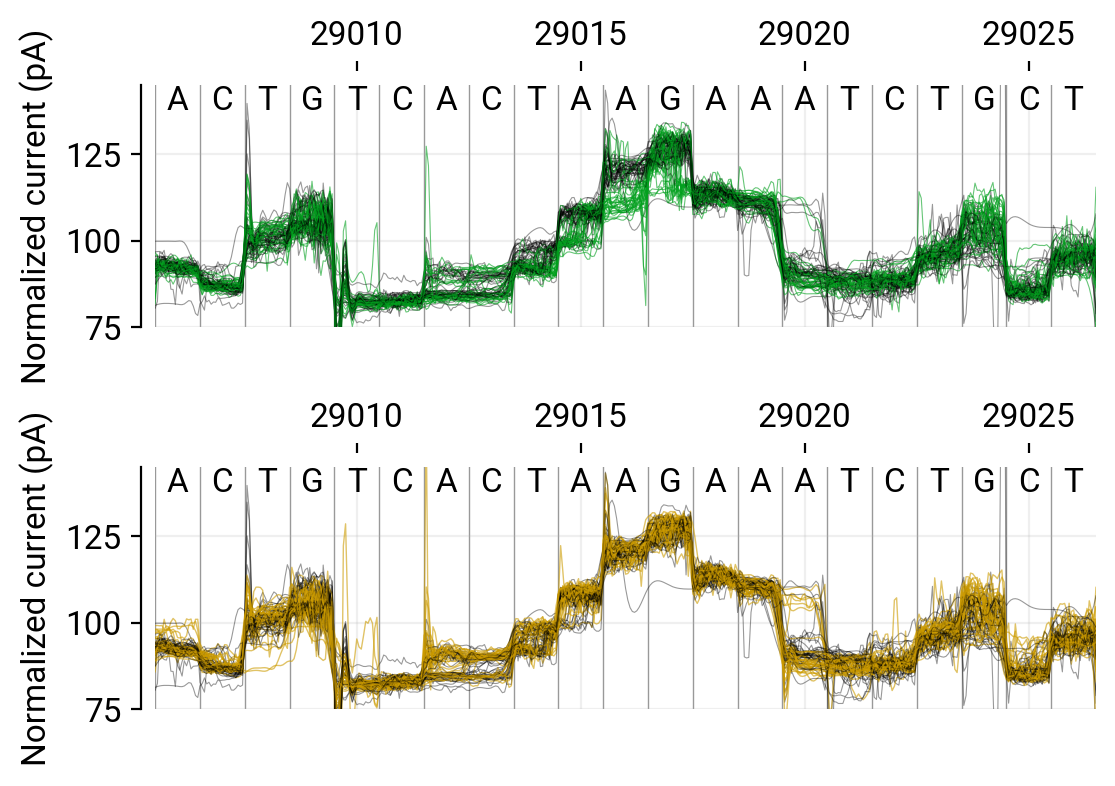

In [269]:
XTICKS = np.arange(LEFT_END-1, RIGHT_END+1, 5)

fig, axes = plt.subplots(2, 1, figsize=(5.74, 4))

ax = axes[0]
for i in range(35):
    if i == 0:
        ctlkwds = {'label': 'IVT'}; virkwds = {'label': 'Viral sgRNA S'}
    else:
        ctlkwds = virkwds = {}
    ax.plot(ctlres_x[i], ctlres_y[i], c='#000000', lw=.4, alpha=.4, zorder=3, **ctlkwds)
    ax.plot(virres_x_S[i], virres_y_S[i], c='#02a01e', lw=.4, alpha=.6, zorder=3, **virkwds)

for p in np.arange(LEFT_END, RIGHT_END):
    ax.axvline(p, c='black', alpha=.4, lw=.5, zorder=1)
    ax.annotate(covseq[p], (p + .5, 145), zorder=4, ha='center', va='top')

for sp in 'top right bottom'.split():
    ax.spines[sp].set_visible(False)

ax.set_xticks(XTICKS + .5)
ax.set_xticklabels(XTICKS + 1)
ax.xaxis.tick_top()
ax.set_ylabel('Normalized current (pA)')
ax.spines['left'].set_position(('outward', 5))
#plt.setp(ax.get_xticklines(), visible=False)
    
ax.set_ylim(75, 145)
#ax.legend(fontsize=10, loc='upper right')
ax.set_xlim(29005, 29026)
ax.grid(alpha=.2)
ax.spines['top'].set_position(('outward', 5))


ax = axes[1]
for i in range(35):
    if i == 0:
        ctlkwds = {'label': 'IVT'}; virkwds = {'label': 'Viral sgRNA N'}
    else:
        ctlkwds = virkwds = {}
    ax.plot(ctlres_x[i], ctlres_y[i], c='#000000', lw=.4, alpha=.4, zorder=3, **ctlkwds)
    ax.plot(virres_x_N[i], virres_y_N[i], c='#cc9b00', lw=.5, alpha=.6, zorder=3, **virkwds)

for p in np.arange(LEFT_END, RIGHT_END):
    ax.axvline(p, c='black', alpha=.4, lw=.5, zorder=1)
    ax.annotate(covseq[p], (p + .5, 145), zorder=4, ha='center', va='top')

for sp in 'top right bottom'.split():
    ax.spines[sp].set_visible(False)

ax.set_xticks(XTICKS + .5)
ax.set_xticklabels(XTICKS + 1)
ax.xaxis.tick_top()
ax.set_ylabel('Normalized current (pA)')
ax.spines['left'].set_position(('outward', 5))
ax.spines['top'].set_position(('outward', 5))
#plt.setp(ax.get_xticklines(), visible=False)
    
ax.set_ylim(75, 145)
#ax.legend(fontsize=10, loc='upper right')
ax.set_xlim(29005, 29026)
ax.grid(alpha=.2)

plt.tight_layout()
plt.savefig('figure-outputs/signal-29016.pdf')

In [322]:
refmodel = kmer_model.loc['TAAGA']
refmodel

level_mean     129.862932
level_stdv       5.559623
sd_mean          5.214372
sd_stdv          2.901019
ig_lambda       16.846307
weight        5331.183458
Name: TAAGA, dtype: float64

In [323]:
from scipy.stats import norm

In [324]:
model_x = np.linspace(90, 150, 100)
model_y = norm.pdf(model_x, refmodel['level_mean'], refmodel['level_stdv'])

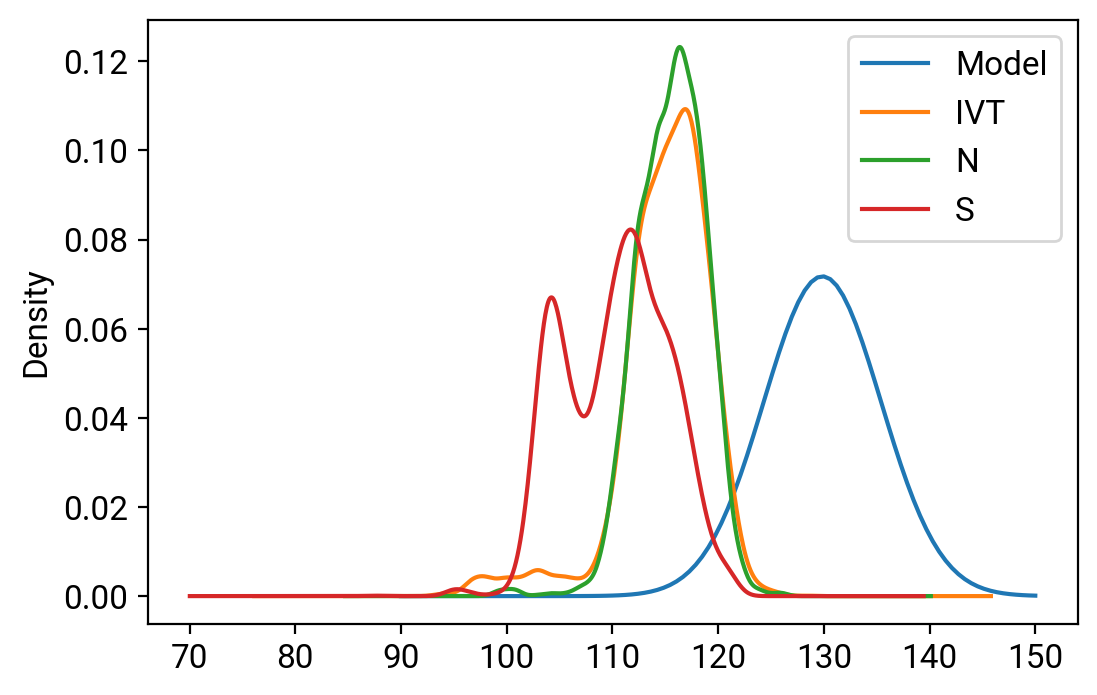

In [325]:
ctl_signals = []
virN_signals = []
virS_signals = []

for i in range(250):
    ctl_matches = (ctlres_x[i] >= 29016) & (ctlres_x[i] < 29017)
    ctl_signals.append(ctlres_y[i][ctl_matches])
    
    virN_matches = (virres_x_N[i] >= 29016) & (virres_x_N[i] < 29017)
    virN_signals.append(virres_y_N[i][virN_matches])
    
    virS_matches = (virres_x_S[i] >= 29016) & (virres_x_S[i] < 29017)
    virS_signals.append(virres_y_S[i][virS_matches])



In [328]:
orfcolors = pd.read_csv('colorcode-rainbow.txt', sep=' ', names=['orf', 'color'], index_col=0)['color'].to_dict()
orfcolors

{'ORF1a': '#c5d9ea',
 'ORF1b': '#e8d2c4',
 'S': '#82c91e',
 'ORF3a': '#3bc9db',
 'E': '#228be6',
 'M': '#748ffc',
 'ORF6': '#7950f2',
 'ORF7a': '#da77f2',
 'ORF7b': '#e64980',
 'ORF8': '#fd7e14',
 'N': '#ffd43b'}

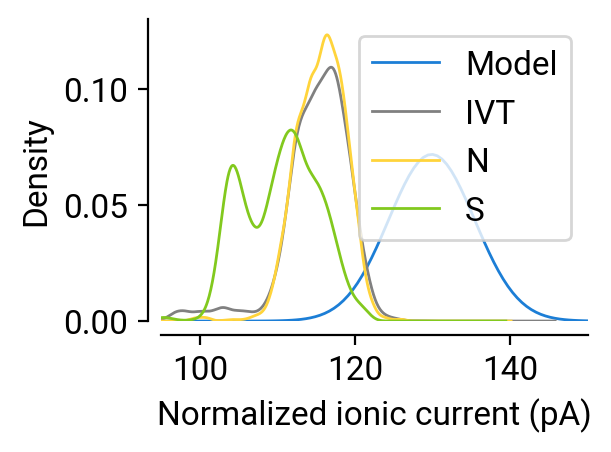

In [347]:
fig, ax = plt.subplots(1, 1, figsize=(2.75, 2))

pd.Series(model_y, index=model_x).plot(label='Model', ax=ax, c='#1c7ed6', lw=1)
pd.Series(np.hstack(ctl_signals)).plot.kde(label='IVT', ax=ax, c='gray', lw=1)
pd.Series(np.hstack(virN_signals)).plot.kde(label='N', ax=ax, c=orfcolors['N'], lw=1)
pd.Series(np.hstack(virS_signals)).plot.kde(label='S', ax=ax, c=orfcolors['S'], lw=1)
plt.legend()
ax.set_xlim(95, 150)

for sp in 'top right'.split():
    ax.spines[sp].set_visible(False)

ax.set_ylim(0, 0.13)
ax.set_xlabel('Normalized ionic current (pA)')
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
#plt.setp(ax.get_yticklabels(), visible=False)
plt.savefig('figure-outputs/signaldist-29016.pdf')